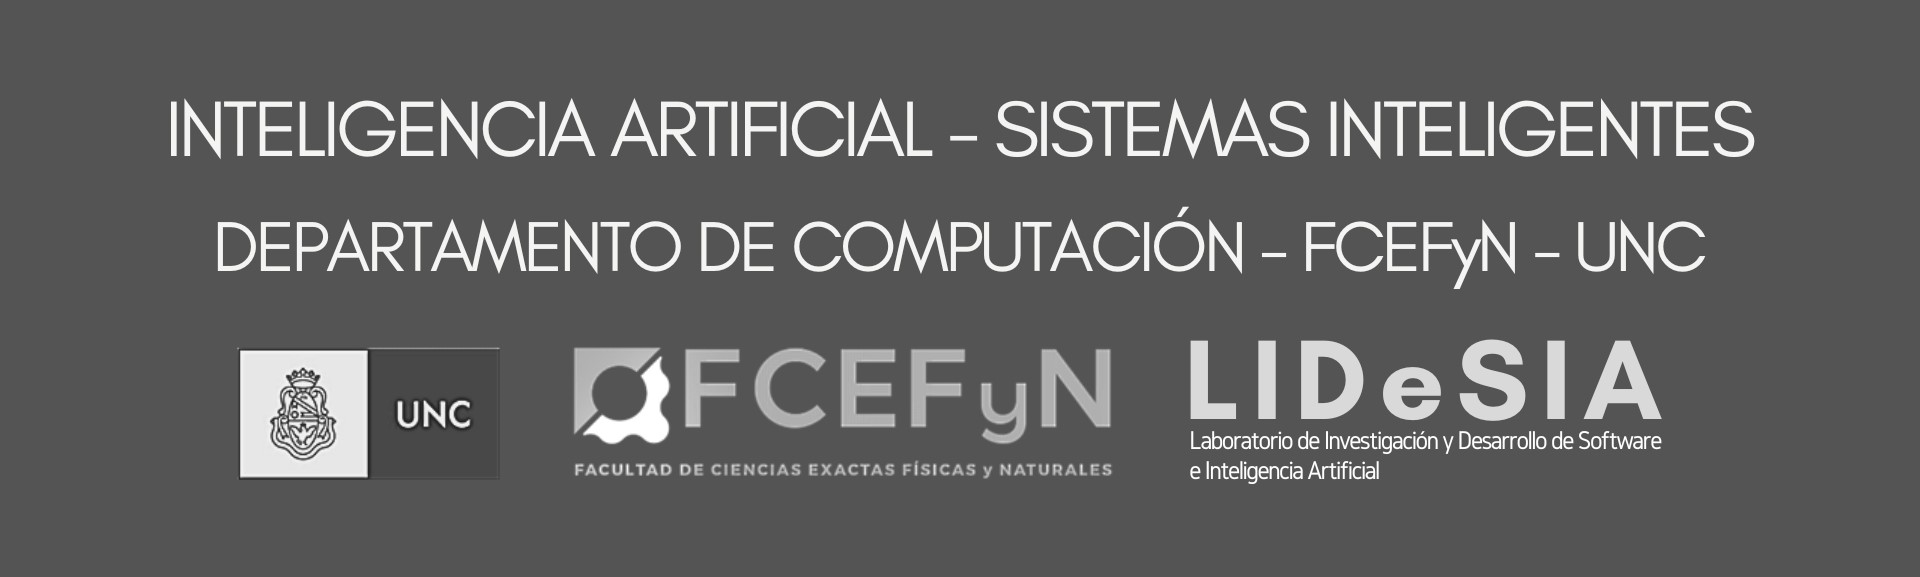


# **TRANSFORMERS**
---


FCEFyN - UNC - Cátedra de Inteligencia Artificial

---

*   Autor/es: Sandro Comerci

*   Directora: Dra. Laura Cecilia Diaz Davila (LIDeSIA - FCEFyN)

---



In [ ]:
!pip install transformers

##Tokenización


La tokenización es un proceso esencial en el procesamiento del lenguaje natural (NLP) que implica dividir un texto en unidades más pequeñas llamadas "tokens". Estos tokens pueden ser palabras, frases, sílabas o caracteres. La tokenización es fundamental para el análisis y procesamiento de texto, ya que permite a las máquinas comprender y trabajar con el texto de manera efectiva.
"Punkt" es un modelo de tokenización en la biblioteca NLTK que se utiliza para dividir el texto tokens

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

nltk.download('stopwords')
nltk.download('punkt')

# Descargar el conjunto de datos de mensajes de reviews de peliculas
nltk.download('movie_reviews')

# Obtener las reseñas de películas
messages = []
labels = []

for category in movie_reviews.categories():
    for file_id in movie_reviews.fileids(category):
        words = movie_reviews.words(file_id)
        message = ' '.join(words)
        messages.append(message)
        labels.append(category)

# Verificar las primeras reseñas
for i in range(5):
    print(f"Mensaje: {messages[i]}")
    print(f"Etiqueta: {labels[i]}\n")

    # Tokenizar el mensaje
    tokens = word_tokenize(messages[i])
    print(f"Tokens: {tokens}\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Mensaje: plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what ' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn ' t snag this one correctly . they seem to have taken this pretty neat concept , but executed it terribly . so what are the problems with the movie ? well , its main problem is that it ' s simply too jumbled . it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , hav

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(messages, labels, test_size=0.2, random_state=42)

# Asignar etiquetas numéricas
y_train = [1 if label == 'pos' else 0 for label in y_train]
y_test = [1 if label == 'pos' else 0 for label in y_test]

# Verificar la cantidad de ejemplos en entrenamiento y prueba
print(f"Ejemplos de entrenamiento: {len(X_train)}")
print(f"Ejemplos de prueba: {len(X_test)}")

Ejemplos de entrenamiento: 1600
Ejemplos de prueba: 400


#Cargar el Tokenizador BERT:

Se carga el tokenizador BERT preentrenado 'bert-base-uncased' utilizando BertTokenizer.from_pretrained('bert-base-uncased'). Este tokenizador se utiliza para dividir los mensajes en tokens que BERT pueda comprender.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch

# Cargar el tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

**Tokenización de los Mensajes y Creación de Entradas BERT:**

Se define una función tokenize_data que toma una lista de mensajes y etiquetas como entrada. La función realiza lo siguiente:
Itera a través de cada mensaje y su etiqueta en los datos de entrenamiento o prueba.
Utiliza el tokenizador BERT para codificar el mensaje. Esto incluye agregar tokens especiales, limitar la longitud a 128 tokens, agregar máscaras de atención y realizar truncamiento si es necesario.
Almacena los input_ids (identificadores de tokens), las máscaras de atención y las etiquetas en listas separadas (input_ids, attention_masks, new_labels).
Finalmente, convierte estas listas en tensores PyTorch.

In [ ]:
# Tokenizar los mensajes y convertirlos en entradas BERT
def tokenize_data(messages, labels):
    input_ids = []
    attention_masks = []
    new_labels = []

    for message, label in zip(messages, labels):
        encoded_dict = tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        new_labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(new_labels)

    return TensorDataset(input_ids, attention_masks, labels)

train_data = tokenize_data(X_train, y_train)
test_data = tokenize_data(X_test, y_test)

# Verificar las dimensiones de los datos
print(f"Dimensiones de datos de entrenamiento: {train_data.tensors[0].shape}")
print(f"Dimensiones de datos de prueba: {test_data.tensors[0].shape}")

Dimensiones de datos de entrenamiento: torch.Size([1600, 128])
Dimensiones de datos de prueba: torch.Size([400, 128])


El modelo BERT (Bidirectional Encoder Representations from Transformers) necesita dos tipos de entradas:



1.   Input IDs (identificadores de tokens): Estos son identificadores únicos para
cada token en el texto. Cada token en el texto se asigna a un identificador numérico específico. BERT utiliza un vocabulario de tokens preentrenado, y cada palabra o subpalabra del texto se mapea a un identificador en ese vocabulario. Los input IDs son una secuencia de estos identificadores que representan el texto de entrada. Además, se suelen agregar tokens especiales al principio y al final de la secuencia (CLS y SEP) para indicar el comienzo y el final de la entrada.

2.   Attention Masks (máscaras de atención): Las máscaras de atención indican cuáles tokens son relevantes y cuáles son relleno. Para las palabras reales del texto, la máscara de atención tiene el valor 1, mientras que para los tokens de relleno (que se agregan para que todas las secuencias tengan la misma longitud), la máscara de atención tiene el valor 0. Esto permite al modelo BERT ignorar los tokens de relleno y centrarse en los tokens importantes del texto.





In [ ]:
# Elegir un índice de secuencia específico (por ejemplo, 0 para la primera secuencia)
sequence_index = 101

# Obtener los identificadores de tokens y las máscaras de atención para la secuencia seleccionada
selected_input_ids = train_data.tensors[0][sequence_index]
selected_attention_mask = train_data.tensors[1][sequence_index]

# Convertir los identificadores de tokens a tokens reales utilizando el tokenizador
decoded_tokens = tokenizer.convert_ids_to_tokens(selected_input_ids)

# Imprimir los tokens y las máscaras de atención
print(f"Tokens : {decoded_tokens}")
print(f"Máscara de Atención: {selected_attention_mask}")

Tokens : ['[CLS]', 'the', 'general', "'", 's', 'daughter', 'will', 'probably', 'be', 'the', 'clever', '##est', 'stupid', 'film', 'we', "'", 'll', 'see', 'this', 'year', '-', '-', 'or', 'perhaps', 'the', 'stupid', '##est', 'clever', 'film', '.', 'it', "'", 's', 'confusing', 'to', 'a', 'critic', 'when', 'so', 'much', 'kn', '##uck', '##le', '##head', '##ed', 'plotting', 'and', 'os', '##ten', '##tat', '##ious', 'direction', 'shares', 'the', 'screen', 'with', 'so', 'much', 'snap', '##py', 'dialogue', 'and', 'crisp', 'character', 'interaction', '.', 'that', ',', 'however', ',', 'is', 'what', 'happens', 'when', 'legendary', 'screenwriter', 'william', 'goldman', 'takes', 'a', 'pass', 'at', 'an', 'otherwise', 'brutally', 'predictable', 'conspiracy', 'thriller', '.', 'the', 'punched', '-', 'up', 'punch', 'lines', 'are', 'ever', 'on', 'the', 'verge', 'of', 'convincing', 'you', 'the', 'general', "'", 's', 'daughter', 'has', 'a', 'brain', 'in', 'its', 'head', ',', 'even', 'as', 'the', 'remaining', 

#Creación del modelo BERT:

Se crea un modelo BERT preentrenado para la clasificación de secuencias utilizando BertForSequenceClassification. En este caso, se utiliza el modelo base "bert-base-uncased". El modelo se inicializa con el número de etiquetas de clasificación, que en este ejemplo es 2 (clasificación binaria).

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup


# Definir el dispositivo (GPU si está disponible, de lo contrario, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear un modelo BERT preentrenado para clasificación de secuencias
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Cargar el modelo en el dispositivo
model.to(device)

# Crear un DataLoader para los datos de entrenamiento y prueba
train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

# Entrenar el modelo
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3

for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        #Realizamos una pasada hacia adelante (forward pass)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        #Extraemos la pérdida (loss) del objeto outputs. La pérdida representa qué tan bien se están haciendo las predicciones del modelo en comparación con las etiquetas reales.
        loss = outputs.loss

        #Realizamos una pasada hacia atrás (backward pass) para calcular los gradientes de la pérdida con respecto a los parámetros del modelo
        loss.backward()

        #Calculamos los gradientes, se utilizan para ajustar los pesos (parámetros) del modelo
        optimizer.step()

        #Antes de procesar el siguiente lote de datos, se reinician los gradientes a cero para evitar acumulaciones
        optimizer.zero_grad()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
y_true = []
y_pred = []

for batch in tqdm(test_dataloader):
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad(): #Esta línea indica que las operaciones dentro de este bloque de código no deben realizar un seguimiento de los gradientes. Esto significa que cualquier cálculo realizado aquí no afectará los parámetros del modelo, lo que es útil cuando se realizan predicciones y no se necesita ajustar los pesos.

        #Pasada hacia adelante
        outputs = model(input_ids, attention_mask=attention_mask)

        #Se extraen las salidas sin procesar del modelo
        logits = outputs.logits

        #Clase con valor mas alto
        predicted_labels = torch.argmax(logits, dim=1)

        y_pred.extend(predicted_labels.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calcular la precisión
accuracy = accuracy_score(y_true, y_pred)
print(f'Precisión en el conjunto de prueba: {accuracy:.2f}')

# Generar informe de clasificación
class_names = ['neg', 'pos']
classification_rep = classification_report(y_true, y_pred, target_names=class_names)
print('Informe de clasificación:')
print(classification_rep)

100%|██████████| 13/13 [00:02<00:00,  4.37it/s]

Precisión en el conjunto de prueba: 0.75
Informe de clasificación:
              precision    recall  f1-score   support

         neg       0.76      0.73      0.75       199
         pos       0.75      0.77      0.76       201

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



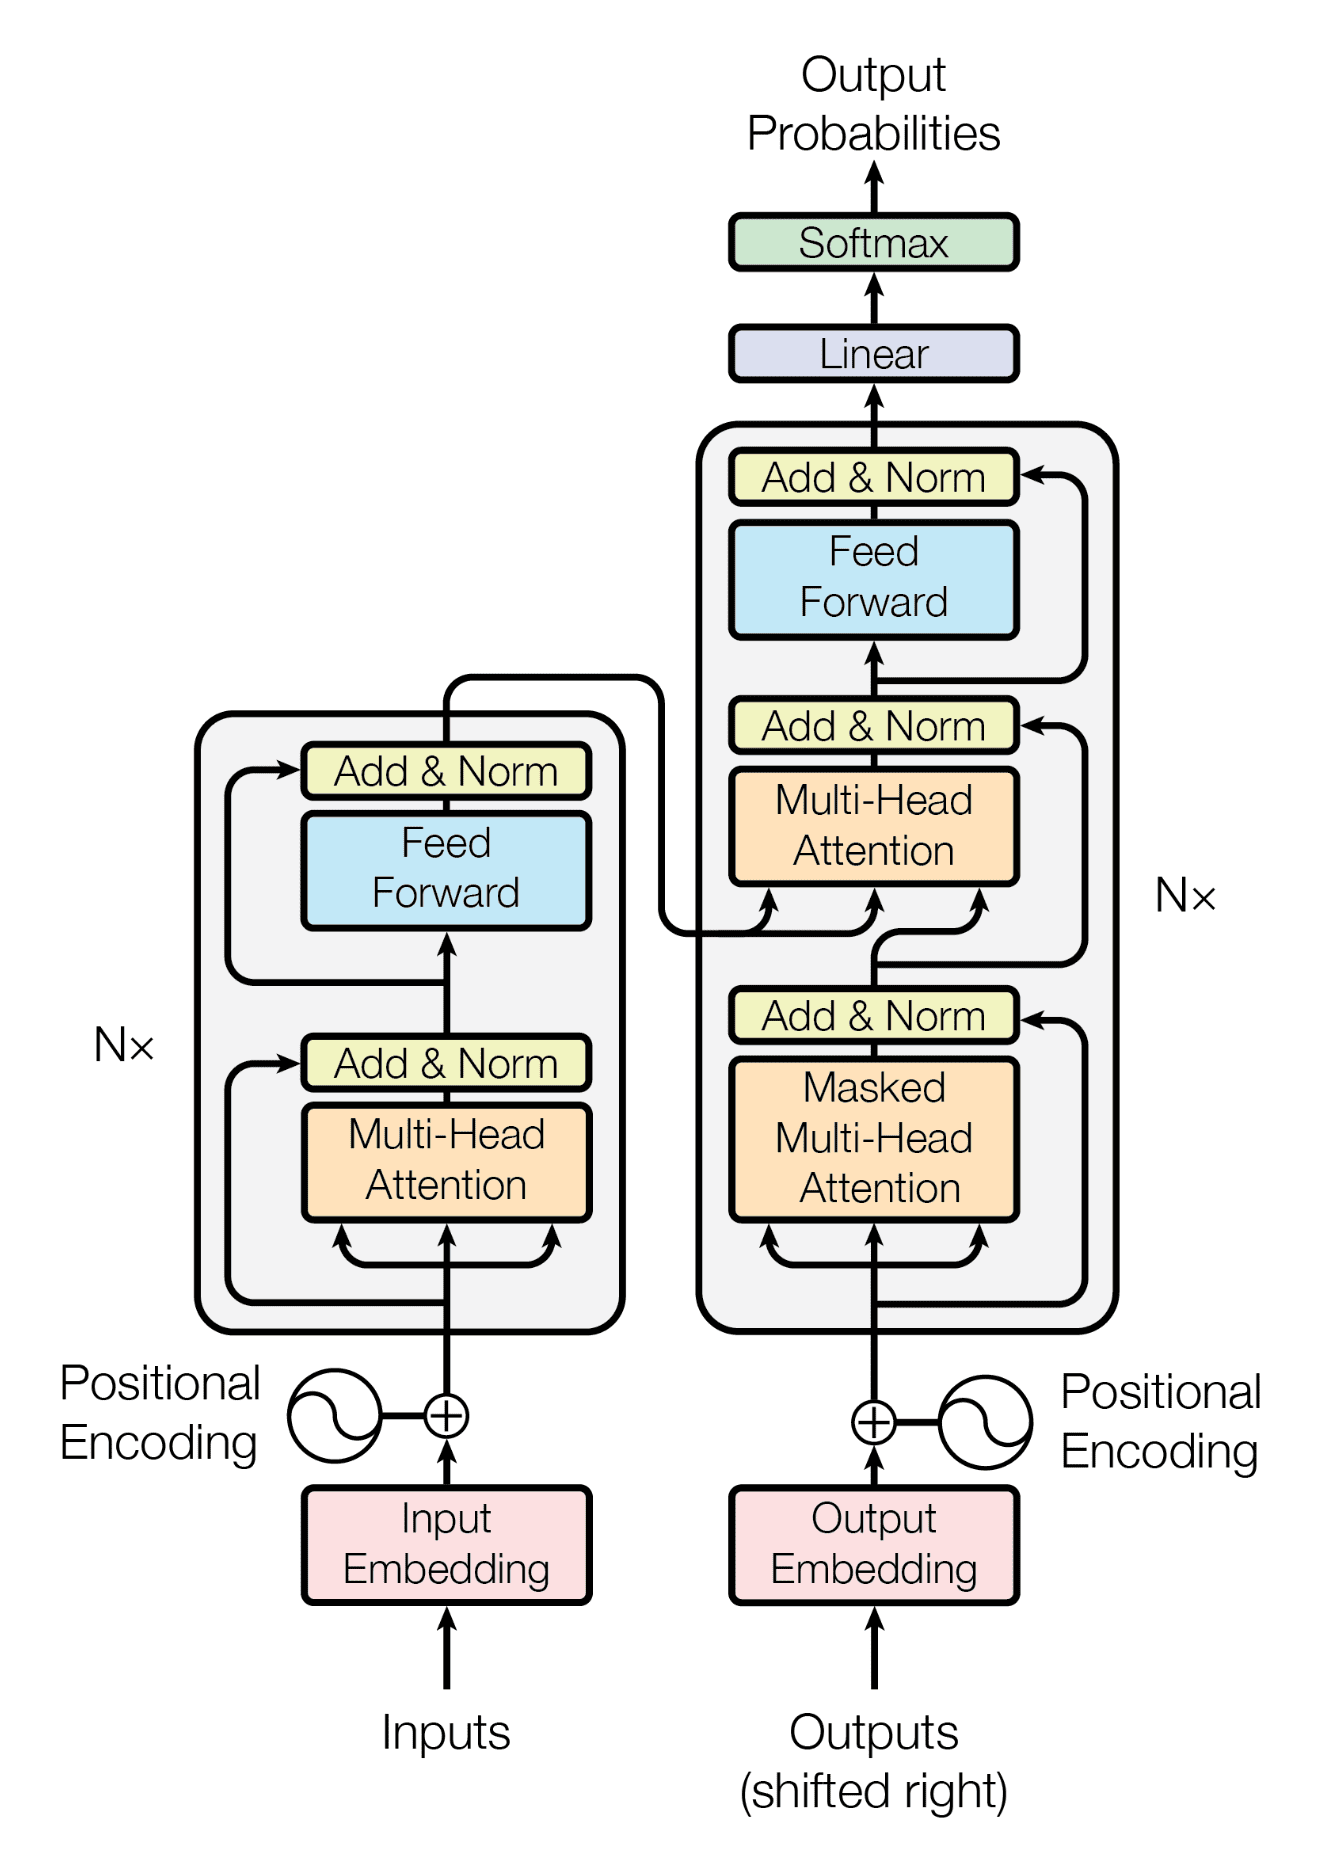

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MultiHeadAttention

def encoder_layer(units, d_model, num_heads, dropout_rate, name="encoder_layer"):
    inputs = layers.Input(shape=(None, d_model), name="inputs")
    padding_mask = layers.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
    d_model, num_heads, name="attention")(query=inputs, key=inputs, value=inputs, attention_mask=padding_mask)
    attention = layers.Dropout(rate=dropout_rate)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = layers.Dense(units=units, activation="relu")(attention)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(rate=dropout_rate)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout_rate):
    inputs = keras.Input(shape=(None, d_model))
    enc_outputs = keras.Input(shape=(None, d_model))
    attention1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs)
    attention1 = layers.Dropout(rate=dropout_rate)(attention1)
    attention1 = layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    attention2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(attention1, attention1)
    attention2 = layers.Dropout(rate=dropout_rate)(attention2)
    attention2 = layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    outputs = layers.Dense(units=units, activation="relu")(attention2)
    outputs = layers.Dense(units=d_model)(outputs)
    outputs = layers.Dropout(rate=dropout_rate)(outputs)
    outputs = layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    return keras.Model(inputs=[inputs, enc_outputs], outputs=outputs, name="decoder_layer")

In [ ]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout_rate):
    inputs = keras.Input(shape=(None,))
    embeddings = layers.Embedding(vocab_size, d_model)(inputs)
    outputs = embeddings
    for _ in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate)(outputs)
    return keras.Model(inputs=inputs, outputs=outputs, name="encoder")

In [ ]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout_rate):
    inputs = keras.Input(shape=(None,))
    enc_outputs = keras.Input(shape=(None, d_model))
    embeddings = layers.Embedding(vocab_size, d_model)(inputs)
    outputs = embeddings
    for _ in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate)(outputs, enc_outputs)
    return keras.Model(inputs=[inputs, enc_outputs], outputs=outputs, name="decoder")

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Añadir dimensiones extra para la máscara de padding
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout_rate):
    inputs = keras.Input(shape=(None,))
    dec_inputs = keras.Input(shape=(None,))

    enc_padding_mask = layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    embeddings = layers.Embedding(vocab_size, d_model)(inputs)
    enc_outputs = encoder(
        vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model,
        num_heads=num_heads, dropout_rate=dropout_rate)(embeddings)

    dec_padding_mask = layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    dec_outputs = decoder(
        vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model,
        num_heads=num_heads, dropout_rate=dropout_rate)(
            dec_inputs, enc_outputs)

    outputs = layers.Dense(vocab_size, activation='softmax')(dec_outputs)

    return keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name='transformer')

In [ ]:
# Crear una instancia del modelo
vocab_size = 10000
num_layers = 1
units = 512
d_model = 256
num_heads = 8
dropout_rate = 0.1

transformer_model = transformer(vocab_size, num_layers, units, d_model, num_heads, dropout_rate)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions = transformer_model([inp, tar_inp], training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer_model.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
# Entrenar el modelo
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

    print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}')
